In [55]:
import os
import json
import shutil
from sklearn.model_selection import train_test_split

def create_dataset_split(data_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Chia dữ liệu thành train, test, validation và tạo file metadata.jsonl.
    
    Args:
        data_dir (str): Thư mục gốc chứa annotations/ và images/
        output_dir (str): Thư mục đầu ra (dataset_split/)
        train_ratio (float): Tỷ lệ dữ liệu cho tập train
        val_ratio (float): Tỷ lệ dữ liệu cho tập validation
        test_ratio (float): Tỷ lệ dữ liệu cho tập test
    """
    # Đảm bảo tỷ lệ hợp lệ
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-5, "Tổng tỷ lệ phải bằng 1.0"

    # Đường dẫn đến thư mục annotations và images
    annotations_dir = os.path.join(data_dir, "entities")
    images_dir = os.path.join(data_dir, "img")
    
    # Tạo danh sách các file ảnh và file JSON
    image_files = [f for f in os.listdir(images_dir) if f.endswith((".jpg", ".png"))]
    json_files = [f for f in os.listdir(annotations_dir) if f.endswith(".txt")]
    
    # Ghép các file ảnh và JSON dựa trên tên
    paired_files = []
    for img_file in image_files:
        # Tìm file JSON tương ứng
        json_file = img_file.rsplit(".", 1)[0] + ".json"
        if json_file in json_files:
            paired_files.append((img_file, json_file))
        else:
            print(f"Cảnh báo: Không tìm thấy file JSON cho ảnh {img_file}, bỏ qua.")
    
    # Chia dữ liệu thành train, validation, test
    train_pairs, temp_pairs = train_test_split(
        paired_files,
        train_size=train_ratio,
        random_state=2022  # Đảm bảo lặp lại được
    )
    val_ratio_adjusted = val_ratio / (val_ratio + test_ratio)
    val_pairs, test_pairs = train_test_split(
        temp_pairs,
        train_size=val_ratio_adjusted,
        random_state=2022
    )
    
    # Tạo thư mục đầu ra
    splits = {
        "train": train_pairs,
        "validation": val_pairs,
        "test": test_pairs
    }
    
    for split, pairs in splits.items():
        split_dir = os.path.join(output_dir, split)
        os.makedirs(split_dir, exist_ok=True)
        
        # Tạo file metadata.jsonl
        metadata_path = os.path.join(split_dir, "metadata.jsonl")
        with open(metadata_path, "w", encoding="utf-8") as f:
            for img_file, json_file in pairs:
                # Đọc file JSON
                with open(os.path.join(annotations_dir, json_file), "r", encoding="utf-8") as jf:
                    annotation = json.load(jf)
                
                # Tạo gt_parse (định dạng Document Parsing)
                gt_parse = {}
                for key, value in annotation.items():
                    gt_parse[key] = value  # Điều chỉnh tùy theo cấu trúc annotation của bạn
                
                # Tạo dòng metadata
                metadata = {
                    "file_name": img_file,
                    "ground_truth": json.dumps({"gt_parse": gt_parse}, ensure_ascii=False)
                }
                f.write(json.dumps(metadata, ensure_ascii=False) + "\n")
                
                # Sao chép file ảnh vào thư mục split
                src_img_path = os.path.join(images_dir, img_file)
                dst_img_path = os.path.join(split_dir, img_file)
                shutil.copy2(src_img_path, dst_img_path)
        
        print(f"Đã tạo split {split} với {len(pairs)} mẫu tại {split_dir}")

if __name__ == "__main__":
    data_dir = r"D:\Private\Project\kaggle\LabAI\Donut\dataset\dataset\training_data"
    output_dir = r"D:\Private\Project\kaggle\LabAI\Donut\donut\dataset1"
    create_dataset_split(data_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15)

Đã tạo split train với 104 mẫu tại D:\Private\Project\kaggle\LabAI\Donut\donut\dataset1\train
Đã tạo split validation với 22 mẫu tại D:\Private\Project\kaggle\LabAI\Donut\donut\dataset1\validation
Đã tạo split test với 23 mẫu tại D:\Private\Project\kaggle\LabAI\Donut\donut\dataset1\test


In [4]:
import os
import json
import shutil
from sklearn.model_selection import train_test_split

def parse_txt_file(txt_path):
    """
    Phân tích file .txt chứa nội dung JSON thuần túy.
    Trả về dictionary từ JSON.
    """
    try:
        with open(txt_path, "r", encoding="utf-8") as f:
            content = f.read().strip()
        
        # Phân tích JSON trực tiếp
        annotation = json.loads(content)
        return annotation
    
    except json.JSONDecodeError as e:
        print(f"Lỗi phân tích JSON trong {txt_path}: {e}")
        return None
    except Exception as e:
        print(f"Lỗi không xác định trong {txt_path}: {e}")
        return None

def create_dataset_split(data_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Chia dữ liệu thành train, validation, test và tạo file metadata.jsonl.
    
    Args:
        data_dir (str): Thư mục gốc chứa entities/ và img/
        output_dir (str): Thư mục đầu ra (dataset_split/)
        train_ratio (float): Tỷ lệ dữ liệu cho tập train
        val_ratio (float): Tỷ lệ dữ liệu cho tập validation
        test_ratio (float): Tỷ lệ dữ liệu cho tập test
    """
    # Đảm bảo tỷ lệ hợp lệ
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-5, "Tổng tỷ lệ phải bằng 1.0"

    # Đường dẫn đến thư mục entities và img
    annotations_dir = os.path.join(data_dir, "entities")
    images_dir = os.path.join(data_dir, "img")
    
    # Lấy danh sách file ảnh và file .txt
    image_files = [f for f in os.listdir(images_dir) if f.endswith((".jpg", ".png"))]
    txt_files = [f for f in os.listdir(annotations_dir) if f.endswith(".txt")]
    
    # Ghép các file ảnh và .txt dựa trên tên
    paired_files = []
    for img_file in image_files:
        txt_file = img_file.rsplit(".", 1)[0] + ".txt"
        if txt_file in txt_files:
            paired_files.append((img_file, txt_file))
        else:
            print(f"Cảnh báo: Không tìm thấy file .txt cho ảnh {img_file}, bỏ qua.")
    
    # Chia dữ liệu thành train, validation, test
    train_pairs, temp_pairs = train_test_split(
        paired_files,
        train_size=train_ratio,
        random_state=2022
    )
    val_ratio_adjusted = val_ratio / (val_ratio + test_ratio)
    val_pairs, test_pairs = train_test_split(
        temp_pairs,
        train_size=val_ratio_adjusted,
        random_state=2022
    )
    
    # Tạo thư mục đầu ra
    splits = {
        "train": train_pairs,
        "validation": val_pairs,
        "test": test_pairs
    }
    
    for split, pairs in splits.items():
        split_dir = os.path.join(output_dir, split)
        os.makedirs(split_dir, exist_ok=True)
        
        # Tạo file metadata.jsonl
        metadata_path = os.path.join(split_dir, "metadata.jsonl")
        with open(metadata_path, "w", encoding="utf-8") as f:
            for img_file, txt_file in pairs:
                # Phân tích file .txt
                annotation = parse_txt_file(os.path.join(annotations_dir, txt_file))
                if annotation is None:
                    print(f"Bỏ qua {img_file} do lỗi phân tích trong {txt_file}")
                    continue
                
                # Tạo gt_parse (sử dụng annotation trực tiếp)
                gt_parse = annotation
                
                # Tạo dòng metadata
                metadata = {
                    "file_name": img_file,
                    "ground_truth": json.dumps({"gt_parse": gt_parse}, ensure_ascii=False)
                }
                f.write(json.dumps(metadata, ensure_ascii=False) + "\n")
                
                # Sao chép file ảnh
                src_img_path = os.path.join(images_dir, img_file)
                dst_img_path = os.path.join(split_dir, img_file)
                shutil.copy2(src_img_path, dst_img_path)
        
        print(f"Đã tạo split {split} với {len(pairs)} mẫu tại {split_dir}")

if __name__ == "__main__":
    data_dir = r"D:\Private\Project\kaggle\LabAI\Donut\donut\dataset"
    output_dir = r"D:\Private\Project\kaggle\LabAI\Donut\donut\dataset1"
    create_dataset_split(data_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15)

Đã tạo split train với 438 mẫu tại D:\Private\Project\kaggle\LabAI\Donut\donut\dataset1\train
Đã tạo split validation với 94 mẫu tại D:\Private\Project\kaggle\LabAI\Donut\donut\dataset1\validation
Đã tạo split test với 94 mẫu tại D:\Private\Project\kaggle\LabAI\Donut\donut\dataset1\test


In [ ]:
!python test.py --dataset_name_or_path D:/Private/Project/kaggle/LabAI/Donut/donut/dataset --pretrained_model_name_or_path D:/Private/Project/kaggle/LabAI/Donut/donut/result_new/train_cord/test_experiment --save_path result/output.json



c:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


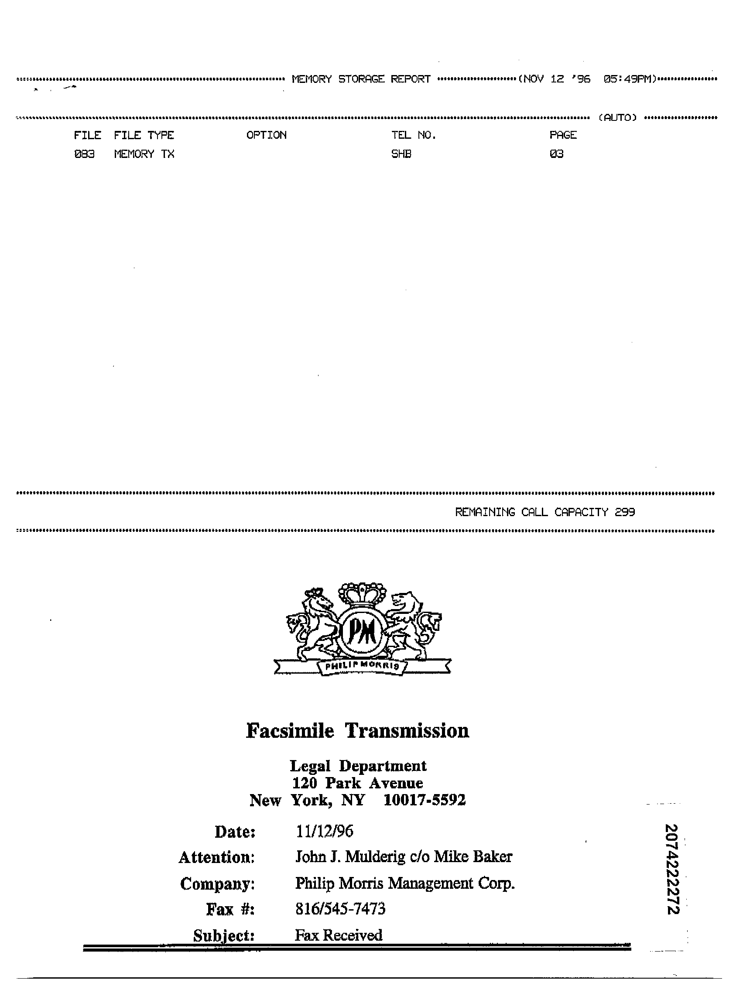

In [1]:
from datasets import load_dataset

dataset = load_dataset(r"D:\Private\Project\kaggle\LabAI\Donut\donut\dataset")
image = dataset['train'][5]['image']
image

In [2]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

processor = DonutProcessor.from_pretrained(r"D:\Private\Project\kaggle\LabAI\Donut\donut\result_new\train_cord\test_experiment")
model = VisionEncoderDecoderModel.from_pretrained(r"D:\Private\Project\kaggle\LabAI\Donut\donut\result_new\train_cord\test_experiment")

You are using a model of type donut to instantiate a model of type vision-encoder-decoder. This is not supported for all configurations of models and can yield errors.


ValueError: A configuraton of type donut cannot be instantiated because not both `encoder` and `decoder` sub-configurations are passed, but only {'_name_or_path': 'naver-clova-ix/donut-base-finetuned-cord-v2', 'align_long_axis': False, 'architectures': ['DonutModel'], 'decoder_layer': 4, 'encoder_layer': [2, 2, 14, 2], 'input_size': [1280, 960], 'max_length': 128, 'max_position_embeddings': 128, 'model_type': 'donut', 'torch_dtype': 'float32', 'transformers_version': '4.25.1', 'window_size': 10, '_commit_hash': None}

In [51]:
from PIL import Image

image = Image.open(r"D:\Private\Project\kaggle\LabAI\Donut\dataset\dataset\training_data\images\00093726.png").convert("RGB")
pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)



torch.Size([1, 3, 1280, 960])


In [52]:
import torch

task_prompt = "<s_cord-v2>"
decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt")["input_ids"]

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

outputs = model.generate(pixel_values.to(device),
                               decoder_input_ids=decoder_input_ids.to(device),
                               max_length=model.decoder.config.max_position_embeddings,
                               early_stopping=True,
                               pad_token_id=processor.tokenizer.pad_token_id,
                               eos_token_id=processor.tokenizer.eos_token_id,
                               use_cache=True,
                               num_beams=1,
                               bad_words_ids=[[processor.tokenizer.unk_token_id]],
                               return_dict_in_generate=True,
                               output_scores=True,)

In [53]:
import re

sequence = processor.batch_decode(outputs.sequences)[0]
sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token
print(sequence)

<s_menu><s_nm> Date: Sentember 21, 1976</s_nm><s_unitprice> 6030</s_unitprice><s_cnt> 85 mm Pilter</s_cnt><sep/><s_nm> Type of Cigarette</s_nm><s_unitprice> mm Bilder</s_nm><s_unitprice> Batch Size 50</s_unitprice><s_cnt> 50</s_cnt><s_price> 26, 1976</s_price><sep/><s_nm> Original Request Made By Dr. A. W. Spears</s_nm><s_unitprice> on September 21, 1976</s_unitprice><s_cnt> W. E. Routh</s_nm><s_unitprice> Routh</s_nm><s_unitprice> Additional Spray</s_nm><s_unitprice> Blend CASING FINAL FLAVOR</s_nm><s_discountprice> 3.4% PMO in EtoH</s_nm><s_discountprice> OGS PHO Fischer Pliters</s_nm><s_unitprice> 20 mm True plastic rod<sep/><s_nm> Maker AMF</s_nm><s_unitprice> 20 mm</s_unitprice><s_cnt> ment Linhth 85 mm</s_nm><s_unitprice> 20</s_unitprice><s_cnt> 25,0</s_unitprice><s_cnt> Process</s_cnt><sep/><s_nm> Weight To be det. (803 mg tobacco)</s_nm><s_unitprice> Rod Length</s_nm><s_unitprice> Pressure Drop To be determined</s_nm><s_discountprice> Ptessure Drop<sep/><s_nm> Filter Length 20 

In [54]:
processor.token2json(sequence)


[{'nm': 'Date: Sentember 21, 1976',
  'unitprice': '6030',
  'cnt': '85 mm Pilter'},
 {'nm': 'Type of Cigarette', 'cnt': '50', 'price': '26, 1976'},
 {'nm': 'Original Request Made By Dr. A. W. Spears',
  'unitprice': 'on September 21, 1976',
  'cnt': {'unitprice': '20'}},
 {'nm': 'denatured alcohoi.lje. This should give',
  'unitprice': [{'nm': 'Filter Length 20 mm',
    'cnt': '1',
    'price': 'Plasticizer'},
   {'nm': 'Tipping Paper 30 mm'}],
  'cnt': {'nm': 'overwrap', 'unitprice': '02: 02:06]'}}]

In [3]:
import torch
from PIL import Image
from transformers import AutoModel, AutoTokenizer, AutoProcessor
import matplotlib.pyplot as plt

model_name = "5CD-AI/ColVintern-1B-v1"

processor =  AutoProcessor.from_pretrained(
    model_name,
    trust_remote_code=True
)
model = AutoModel.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    trust_remote_code=True,
).eval().cuda()

Explicitly passing a `revision` is encouraged when loading a feature extractor with custom code to ensure no malicious code has been contributed in a newer revision.
Could not locate the 5CD-AI/ColVintern-1B-v1--processing_colinternvl2.py inside 5CD-AI/ColVintern-1B-v1.


OSError: 5CD-AI/ColVintern-1B-v1 does not appear to have a file named 5CD-AI/ColVintern-1B-v1--processing_colinternvl2.py. Checkout 'https://huggingface.co/5CD-AI/ColVintern-1B-v1/main' for available files.